In [50]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load the dataset
file_path = 'nyc-rolling-sales.csv'
data_raw = pd.read_csv(file_path)
data = data_raw.copy()

# Overview

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

In [52]:
data.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [53]:
# Drop unnecessary columns
data_cleaned = data.drop(columns=["Unnamed: 0", "BLOCK", "ADDRESS", 'EASE-MENT', 'APARTMENT NUMBER'])

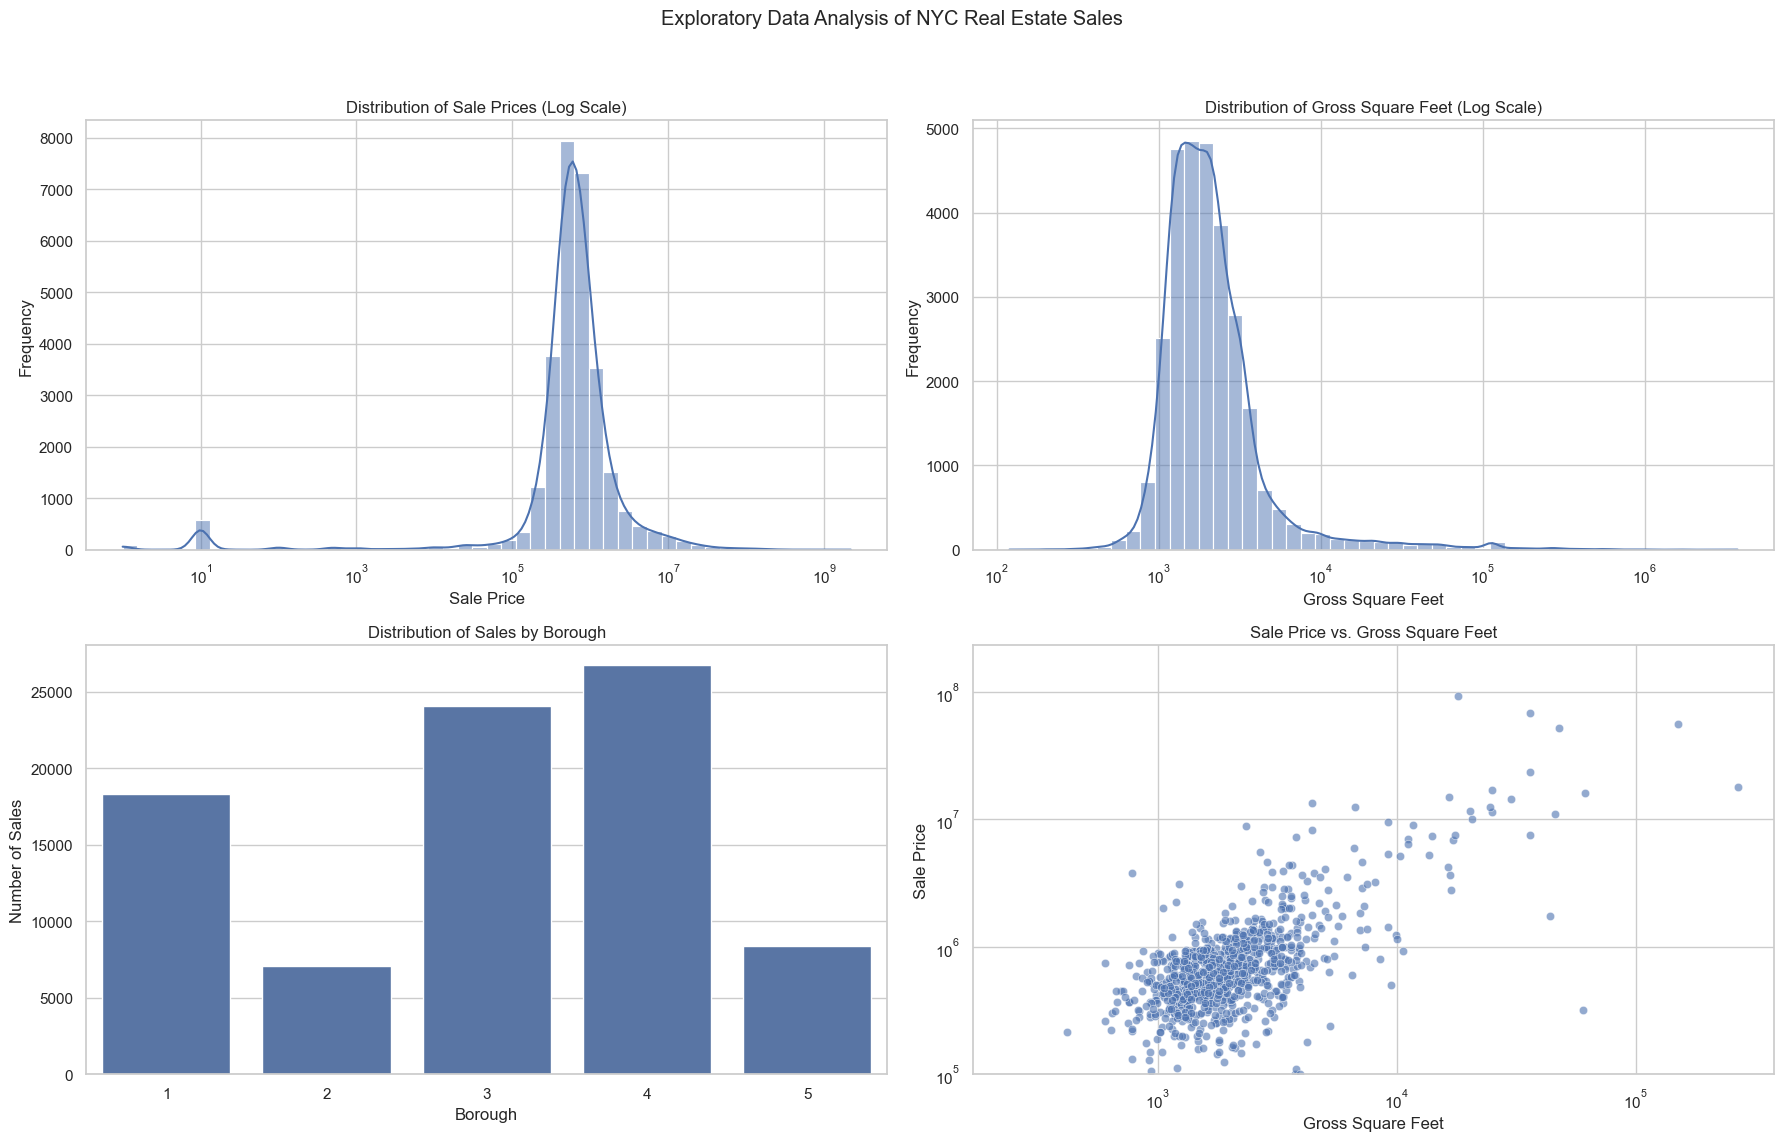

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization styles
sns.set(style="whitegrid")

# Clean 'SALE PRICE' and 'GROSS SQUARE FEET' columns and convert to numeric
data_cleaned['SALE PRICE'] = pd.to_numeric(data_cleaned['SALE PRICE'], errors='coerce')
data_cleaned['GROSS SQUARE FEET'] = pd.to_numeric(data_cleaned['GROSS SQUARE FEET'], errors='coerce')

# Filter out rows with non-numeric or NaN values in 'SALE PRICE' and 'GROSS SQUARE FEET'
filtered_data = data_cleaned[data_cleaned['SALE PRICE'].notna() & (data_cleaned['SALE PRICE'] > 0)]
filtered_data = filtered_data[filtered_data['GROSS SQUARE FEET'].notna() & (filtered_data['GROSS SQUARE FEET'] > 0)]

# Define the figure for subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Exploratory Data Analysis of NYC Real Estate Sales')

# Plot distribution of sale prices (ignoring records with $0 sale price)
sns.histplot(filtered_data['SALE PRICE'], bins=50, ax=axes[0, 0], kde=True, log_scale=True)
axes[0, 0].set_title('Distribution of Sale Prices (Log Scale)')
axes[0, 0].set_xlabel('Sale Price')
axes[0, 0].set_ylabel('Frequency')

# Plot distribution of gross square feet
sns.histplot(filtered_data['GROSS SQUARE FEET'], bins=50, ax=axes[0, 1], kde=True, log_scale=True)
axes[0, 1].set_title('Distribution of Gross Square Feet (Log Scale)')
axes[0, 1].set_xlabel('Gross Square Feet')
axes[0, 1].set_ylabel('Frequency')

# Borough distribution
borough_count = data_cleaned['BOROUGH'].value_counts().sort_index()
sns.barplot(x=borough_count.index, y=borough_count.values, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Sales by Borough')
axes[1, 0].set_xlabel('Borough')
axes[1, 0].set_ylabel('Number of Sales')

# Sale price vs. Gross square feet (Sample of 1000 records for visibility)
sample_data = filtered_data.sample(n=1000, random_state=1)
sns.scatterplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=sample_data, ax=axes[1, 1], alpha=0.6)
axes[1, 1].set_title('Sale Price vs. Gross Square Feet')
axes[1, 1].set_xlabel('Gross Square Feet')
axes[1, 1].set_ylabel('Sale Price')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].set_ylim(bottom=100000)  # Exclude extremely low sale prices for clarity

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Going into Detail

In [55]:
# Convert columns to numeric, handling non-numeric values
data_cleaned["LAND SQUARE FEET"] = pd.to_numeric(data_cleaned["LAND SQUARE FEET"], errors='coerce')
data_cleaned = data_cleaned[data_cleaned['SALE PRICE'].notna()]

In [56]:
# Feature engineering
data_cleaned['SALE DATE'] = pd.to_datetime(data_cleaned['SALE DATE'])
data_cleaned['SALE YEAR'] = data_cleaned['SALE DATE'].dt.year
data_cleaned['SALE MONTH'] = data_cleaned['SALE DATE'].dt.month

# cross feature sale year and sale month
data_cleaned['SALE YEAR_MONTH'] = data_cleaned['SALE YEAR'].astype(str) + '-' + data_cleaned['SALE MONTH'].astype(str)
data_cleaned.drop(columns=['SALE DATE', 'SALE MONTH'], inplace=True)

In [57]:
# Group "BUILDING CLASS AT PRESENT" and "TAX CLASS AT PRESENT"
# Ensure 'TAX CLASS AT PRESENT' is string to safely use string methods
data_cleaned['TAX CLASS AT PRESENT'] = data_cleaned['TAX CLASS AT PRESENT'].astype(str)
data_cleaned['TAX CLASS AT PRESENT'] = data_cleaned['TAX CLASS AT PRESENT'].apply(lambda x: '1' if x in ['1', '1A', '1B', '1C'] else ('2' if x.startswith('2') else x))

# Ensure 'TAX CLASS AT TIME OF SALE' is string to safely use string methods
data_cleaned['TAX CLASS AT TIME OF SALE'] = data_cleaned['TAX CLASS AT TIME OF SALE'].astype(str)
data_cleaned['TAX CLASS AT TIME OF SALE'] = data_cleaned['TAX CLASS AT TIME OF SALE'].apply(lambda x: '1' if x in ['1', '1A', '1B', '1C'] else ('2' if x.startswith('2') else x))

In [58]:
def transform_building_class(value):
    if pd.notnull(value) and value.strip() and value.strip()[0].isalpha():
        return ord(value[0].upper()) - ord('A') + 1
    else:
        return np.nan  # Return NaN for empty strings and NaN values

# Apply the transformation
data_cleaned['BUILDING CLASS AT PRESENT TRANSFORMED'] = data_cleaned['BUILDING CLASS AT PRESENT'].apply(transform_building_class)
data_cleaned['BUILDING CLASS AT TIME OF SALE TRANSFORMED'] = data_cleaned['BUILDING CLASS AT TIME OF SALE'].apply(transform_building_class)

# Calculate medians of the transformed columns, excluding NaN values
median_present = data_cleaned['BUILDING CLASS AT PRESENT TRANSFORMED'].median()
median_time_of_sale = data_cleaned['BUILDING CLASS AT TIME OF SALE TRANSFORMED'].median()

# Replace NaN values with the median
data_cleaned['BUILDING CLASS AT PRESENT TRANSFORMED'].fillna(median_present, inplace=True)
data_cleaned['BUILDING CLASS AT TIME OF SALE TRANSFORMED'].fillna(median_time_of_sale, inplace=True)

# Optionally, if you want to remove the original columns
data_cleaned.drop(['BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE'], axis=1, inplace=True)

# Rename transformed columns back to original if desired
data_cleaned.rename(columns={
    'BUILDING CLASS AT PRESENT TRANSFORMED': 'BUILDING CLASS AT PRESENT',
    'BUILDING CLASS AT TIME OF SALE TRANSFORMED': 'BUILDING CLASS AT TIME OF SALE'
}, inplace=True)


In [59]:
# Mapping borough names (assuming 'BOROUGH' column exists and is numeric 1-5)
borough_mapping = {1: 'Manhattan', 2: 'Brooklyn', 3: 'Queens', 4: 'The Bronx', 5: 'Staten Island'}
data_cleaned['BOROUGH'] = data_cleaned['BOROUGH'].map(borough_mapping)

In [60]:
# Handle $0 Sale Price transactions and outliers
data_filtered = data_cleaned[data_cleaned["SALE PRICE"] > 0].copy()
data_filtered = data_cleaned[data_cleaned["SALE PRICE"] > 0].copy()
Q1 = data_filtered["SALE PRICE"].quantile(0.25)
Q3 = data_filtered["SALE PRICE"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data_filtered.loc[data_filtered["SALE PRICE"] < lower_bound, "SALE PRICE"] = lower_bound
data_filtered.loc[data_filtered["SALE PRICE"] > upper_bound, "SALE PRICE"] = upper_bound

In [61]:
# Calculate "Age of Property"
current_year = datetime.now().year
data_filtered['AGE OF PROPERTY'] = current_year - data_filtered['YEAR BUILT'].replace(0, np.nan)
median_year_built = data_filtered['YEAR BUILT'].median()
data_filtered['YEAR BUILT'].fillna(median_year_built, inplace=True)
data_filtered['AGE OF PROPERTY'] = data_filtered['AGE OF PROPERTY'].fillna(current_year - median_year_built)
data_filtered.drop(columns=['YEAR BUILT'], inplace=True)

In [62]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59759 entries, 0 to 84547
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         59759 non-null  object 
 1   NEIGHBORHOOD                    59759 non-null  object 
 2   BUILDING CLASS CATEGORY         59759 non-null  object 
 3   TAX CLASS AT PRESENT            59759 non-null  object 
 4   LOT                             59759 non-null  int64  
 5   ZIP CODE                        59759 non-null  int64  
 6   RESIDENTIAL UNITS               59759 non-null  int64  
 7   COMMERCIAL UNITS                59759 non-null  int64  
 8   TOTAL UNITS                     59759 non-null  int64  
 9   LAND SQUARE FEET                38571 non-null  float64
 10  GROSS SQUARE FEET               38020 non-null  float64
 11  TAX CLASS AT TIME OF SALE       59759 non-null  object 
 12  SALE PRICE                      59759

In [63]:
# drop building class category
data_filtered.drop(columns=['BUILDING CLASS CATEGORY'], inplace=True)

In [64]:
# Ensure the conversion to integers is definitive by removing non-numeric values first if necessary
# This step assumes you've validated that direct numeric conversion is appropriate for your data
data_filtered['TAX CLASS AT PRESENT'] = pd.to_numeric(data_filtered['TAX CLASS AT PRESENT'], errors='coerce')
data_filtered['TAX CLASS AT TIME OF SALE'] = pd.to_numeric(data_filtered['TAX CLASS AT TIME OF SALE'], errors='coerce')

# Now, you can safely impute missing values with the median for these numeric columns
data_filtered['TAX CLASS AT PRESENT'].fillna(data_filtered['TAX CLASS AT PRESENT'].median(), inplace=True)
data_filtered['TAX CLASS AT TIME OF SALE'].fillna(data_filtered['TAX CLASS AT TIME OF SALE'].median(), inplace=True)

# Converting to integers after imputation
data_filtered['TAX CLASS AT PRESENT'] = data_filtered['TAX CLASS AT PRESENT'].astype(int)
data_filtered['TAX CLASS AT TIME OF SALE'] = data_filtered['TAX CLASS AT TIME OF SALE'].astype(int)


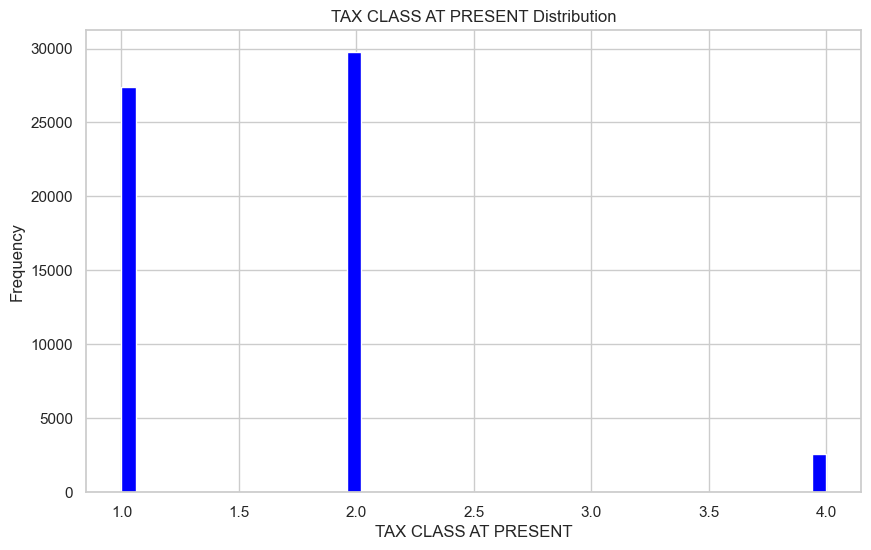

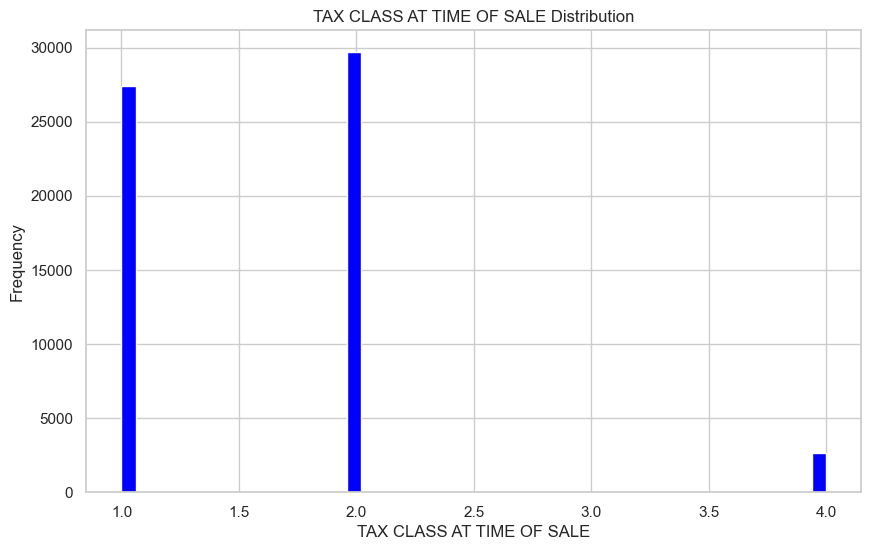

In [65]:
# distribution of TAX CLASS AT PRESENT, TAX CLASS AT TIME OF SALE using plots
import matplotlib.pyplot as plt

# Plot TAX CLASS AT PRESENT distribution
plt.figure(figsize=(10, 6))
plt.hist(data_filtered["TAX CLASS AT PRESENT"], bins=50, color="blue")
plt.xlabel("TAX CLASS AT PRESENT")
plt.ylabel("Frequency")
plt.title("TAX CLASS AT PRESENT Distribution")
plt.show()

# Plot TAX CLASS AT TIME OF SALE distribution
plt.figure(figsize=(10, 6))
plt.hist(data_filtered["TAX CLASS AT TIME OF SALE"], bins=50, color="blue")
plt.xlabel("TAX CLASS AT TIME OF SALE")
plt.ylabel("Frequency")
plt.title("TAX CLASS AT TIME OF SALE Distribution")
plt.show()


In [66]:
# drop tax class at present
data_filtered.drop(columns=['TAX CLASS AT PRESENT'], inplace=True)

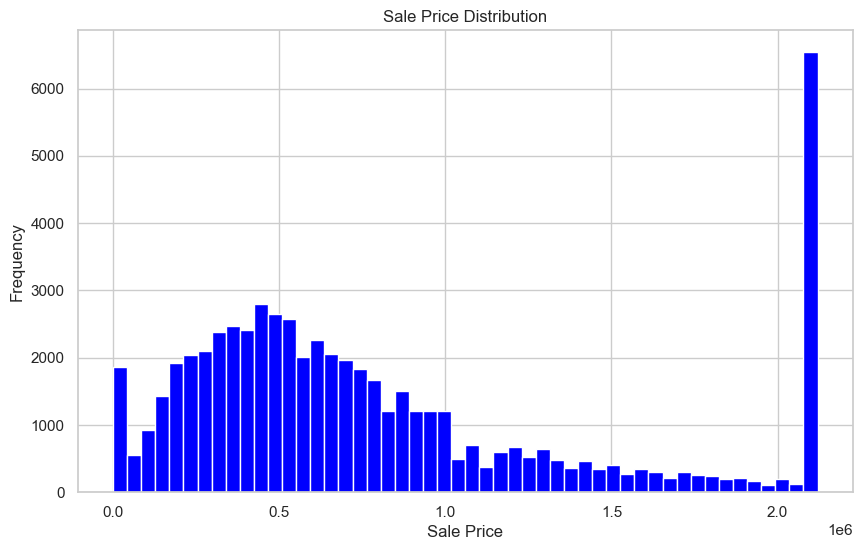

In [67]:
# sale price distribution plot
import matplotlib.pyplot as plt

# Plot sale price distribution
plt.figure(figsize=(10, 6))
plt.hist(data_filtered["SALE PRICE"], bins=50, color="blue")
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.title("Sale Price Distribution")
plt.show()


In [68]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59759 entries, 0 to 84547
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         59759 non-null  object 
 1   NEIGHBORHOOD                    59759 non-null  object 
 2   LOT                             59759 non-null  int64  
 3   ZIP CODE                        59759 non-null  int64  
 4   RESIDENTIAL UNITS               59759 non-null  int64  
 5   COMMERCIAL UNITS                59759 non-null  int64  
 6   TOTAL UNITS                     59759 non-null  int64  
 7   LAND SQUARE FEET                38571 non-null  float64
 8   GROSS SQUARE FEET               38020 non-null  float64
 9   TAX CLASS AT TIME OF SALE       59759 non-null  int64  
 10  SALE PRICE                      59759 non-null  float64
 11  SALE YEAR                       59759 non-null  int32  
 12  SALE YEAR_MONTH                 59759

In [69]:
# drop zip code
data_filtered.drop(columns=['ZIP CODE'], inplace=True)

In [70]:
data_filtered.head()

,BOROUGH,NEIGHBORHOOD,LOT,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE YEAR,SALE YEAR_MONTH,BUILDING CLASS AT PRESENT,BUILDING CLASS AT TIME OF SALE,AGE OF PROPERTY
0,Manhattan,ALPHABET CITY,6,5,0,5,1633.0,6440.0,2,2120000.0,2017,2017-7,3.0,3,124.0
3,Manhattan,ALPHABET CITY,21,10,0,10,2272.0,6794.0,2,2120000.0,2016,2016-9,3.0,3,111.0
4,Manhattan,ALPHABET CITY,55,6,0,6,2369.0,4615.0,2,2120000.0,2016,2016-11,3.0,3,124.0
6,Manhattan,ALPHABET CITY,32,8,0,8,1750.0,4226.0,2,2120000.0,2016,2016-9,3.0,3,104.0
9,Manhattan,ALPHABET CITY,153,24,0,24,4489.0,18523.0,2,2120000.0,2016,2016-11,4.0,4,104.0


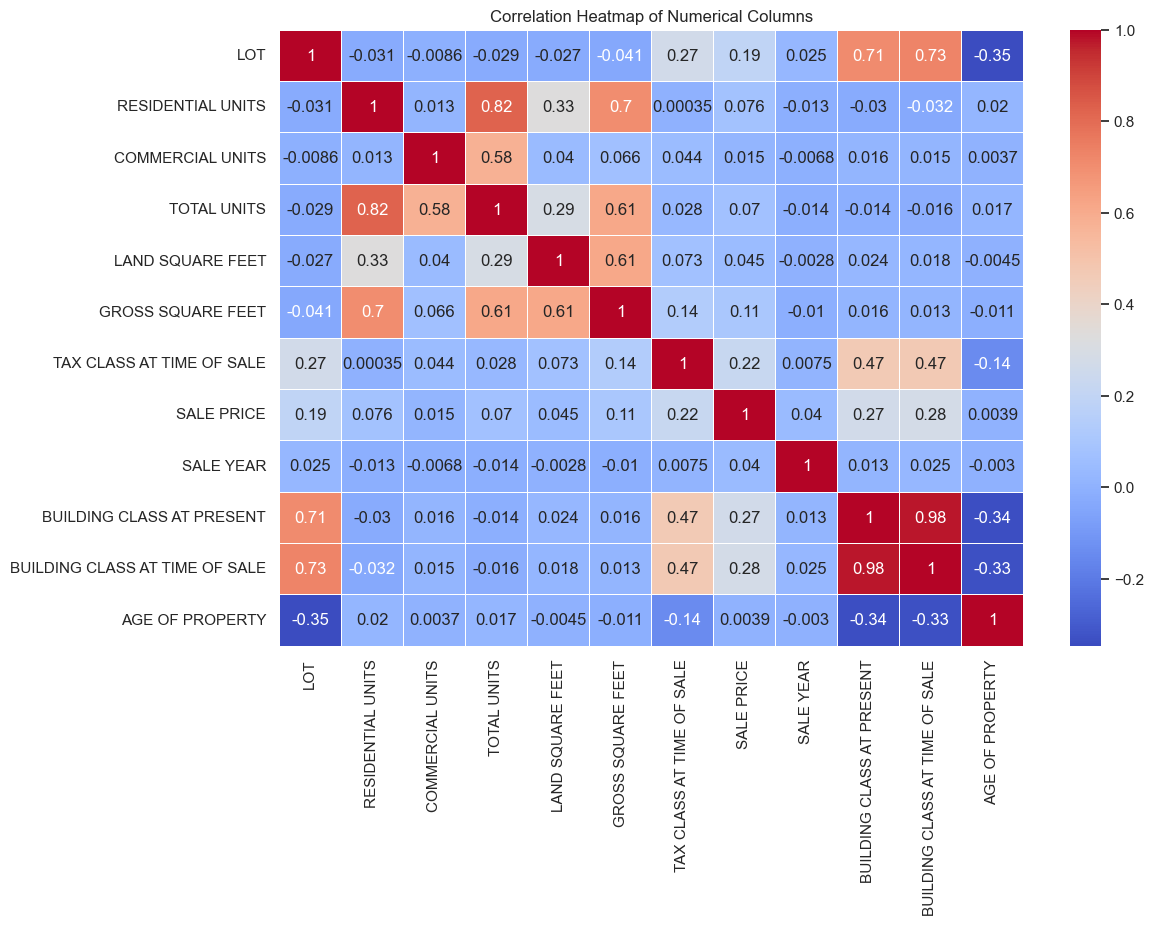

In [71]:
numerical_cols = data_filtered.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numerical_cols.corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

In [72]:
# save data_filtered as csv named data_cleaned.csv
data_filtered.to_csv('data_cleaned.csv', index=False)